## Read data

In [20]:
import numpy as np

In [21]:
def rdnumpy(txtname):
    f = open(txtname)
    line = f.readlines()
    lines = len(line)  # row number
    for l in line:
        le = l.strip('\n').split(',')
        columns = len(le)-1  # col
        #print(le)
        #print(columns)
 
    A = np.zeros((lines, columns+1), dtype=np.single)
    print("read lines:",lines)
    print("read columns:",columns+1)
    A_row = 0
    for lin in line:
        #print(A_row)
        list = lin.strip('\n').split(',')
        A[A_row:] = list[0:columns+1]
        A_row += 1
    return A

# Model begin

In [22]:
import numpy as np
import torch
from torch.utils.data import Dataset,DataLoader
from torchvision.transforms import ToTensor, ToPILImage, Lambda
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## set the parameters

In [23]:
n_epochs = 3
batch_size_train = 16 #32,或者16-由於數據集比較小
batch_size_test = 725*4
learning_rate = 0.0001 #0.0001
momentum = 0.5
log_interval = 10
random_seed = 1
torch.manual_seed(random_seed)

## data loader

In [24]:
class ScottTrainDataset(Dataset):
    def __init__(self, transform=None, target_transform=None):
        TrainDataf1=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\CNN_DSMsFilter_16Fea\MTrainGf1.txt"))
        TrainDataw0=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\CNN_DSMsFilter_16Fea\MTrainGw0.txt"))
        TrainDatam3=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\CNN_DSMsFilter_16Fea\MTrainGm3.txt"))
        TrainDataq4=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\CNN_DSMsFilter_16Fea\MTrainGq4.txt"))
        
        self.AllTrainData=torch.cat((TrainDataw0,TrainDataf1,TrainDatam3,TrainDataq4),0)
        # 定义transform
        self.transform = transform
        self.target_transform = target_transform
 
    def __len__(self):
        '''返回数据集中的样本数'''
        return 1725*4
 
    def __getitem__(self, index):#需要第index個的數據
        '''获取数据的方法，会和Dataloader连用'''
        i=index;        
        startRow=i*8;
        enRow=(i+1)*8;
        nowData=self.AllTrainData[startRow:enRow,2:18]
        
        if index>=0 and index<1725:
            nowLabel=1
        elif index>=1725 and index<1725*2:
            nowLabel=0
        elif index>=1725*2 and index<1725*3:
            nowLabel=3
        else:
            nowLabel=2 #no 4 here
            
        if self.transform:
            nowData = self.transform(nowData)
        if self.target_transform:
            nowLabel = self.target_transform(nowLabel)
        '''
        if nowLabel==0:
            nowLabel = torch.FloatTensor([1, 0])
        else:
            nowLabel = torch.FloatTensor([0, 1])
        '''
        return nowData, nowLabel#需要返回數據和標簽

In [25]:
class ScottTestDataset(Dataset):
    def __init__(self, transform=None, target_transform=None):
        TestDataf1=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\CNN_DSMsFilter_16Fea\MTestGf1.txt"))
        TestDataw0=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\CNN_DSMsFilter_16Fea\MTestGw0.txt"))
        TestDatam3=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\CNN_DSMsFilter_16Fea\MTestGm3.txt"))
        TestDataq4=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\CNN_DSMsFilter_16Fea\MTestGq4.txt"))
        
        self.AllTrainData=torch.cat((TestDataw0,TestDataf1,TestDatam3,TestDataq4),0)
        # 定义transform
        self.transform = transform
        self.target_transform = target_transform
 
    def __len__(self):
        '''返回数据集中的样本数'''
        return 725*4
 
    def __getitem__(self, index):#需要第index個的數據
        '''获取数据的方法，会和Dataloader连用'''
        i=index;        
        startRow=i*8;
        enRow=(i+1)*8;
        nowData=self.AllTrainData[startRow:enRow,2:18]
        
        if index>=0 and index<725:
            nowLabel=1
        elif index>=725 and index<725*2:
            nowLabel=0
        elif index>=725*2 and index<725*3:
            nowLabel=3
        else:
            nowLabel=2 #no 4 here
            
        if self.transform:
            nowData = self.transform(nowData)
        if self.target_transform:
            nowLabel = self.target_transform(nowLabel)
            
        '''
        if nowLabel==0:
            nowLabel = torch.FloatTensor([1, 0])
        else:
            nowLabel = torch.FloatTensor([0, 1])
        '''
            
        return nowData, nowLabel#需要返回數據和標簽

In [26]:
train_loader = torch.utils.data.DataLoader(ScottTrainDataset(),
    batch_size=batch_size_train, shuffle=True)


test_loader = torch.utils.data.DataLoader(ScottTestDataset(),
    batch_size=batch_size_test, shuffle=True)

read lines: 13800
read columns: 19
read lines: 13800
read columns: 19
read lines: 13800
read columns: 19
read lines: 13800
read columns: 19
read lines: 5800
read columns: 19
read lines: 5800
read columns: 19
read lines: 5800
read columns: 19
read lines: 5800
read columns: 19


In [27]:
#for batch_idx, (data, target) in enumerate(train_loader):
    #print (batch_idx)
    #print(data, target)
    #print(target)

# Net Work

In [28]:
#https://zhuanlan.zhihu.com/p/199624393
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=2, padding=1)
        self.conv2 = nn.Conv2d(20,40, kernel_size=2, padding=1)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 60)#60
        self.fc2 = nn.Linear(60, 4)
    def forward(self, x):
        ##print(x)#
        #print(x.shape)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        #print("relu1:")
        #print(x.shape)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        #print("relu2:")
        #print(x.shape)
        x = x.view(-1,320)
        #print("view:")
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print("relu3:")
        #print(x.shape)
        x = F.dropout(x, training=self.training) 
        #print("dropout")
        #print(x.shape)
        x = self.fc2(x)
        #print("FULL con")
        #print(x.shape)
        x= F.log_softmax(x, dim=-1)
        #print("softmax")
        #print(x.shape)
        return x
        #return F.log_softmax(x, dim=-1)
        
network = Net()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

In [29]:
'''
#https://zhuanlan.zhihu.com/p/199624393
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(10,20, kernel_size=3, padding=1)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(40, 30)#15--50-->73
        self.fc2 = nn.Linear(30, 4)
    def forward(self, x):
        #print(x)
        #print(x.shape)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        #print("relu1:")
        #print(x.shape)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        #print("relu2:")
        #print(x.shape)
        x = x.view(-1,40)
        #print("view:")
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print("relu3:")
        #print(x.shape)
        x = F.dropout(x, training=self.training) 
        #print("dropout")
        #print(x.shape)
        x = self.fc2(x)
        #return x
        return F.log_softmax(x, dim=-1)
network = Net()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
'''

'\n#https://zhuanlan.zhihu.com/p/199624393\nimport torch.nn as nn\nimport torch.nn.functional as F\nimport torch.optim as optim\n\nclass Net(nn.Module):\n    def __init__(self):\n        super(Net, self).__init__()\n        self.conv1 = nn.Conv2d(1, 10, kernel_size=3, padding=1)\n        self.conv2 = nn.Conv2d(10,20, kernel_size=3, padding=1)\n        self.conv2_drop = nn.Dropout2d()\n        self.fc1 = nn.Linear(40, 30)#15--50-->73\n        self.fc2 = nn.Linear(30, 4)\n    def forward(self, x):\n        #print(x)\n        #print(x.shape)\n        x = F.relu(F.max_pool2d(self.conv1(x), 2))\n        #print("relu1:")\n        #print(x.shape)\n        x = F.relu(F.max_pool2d(self.conv2(x), 2))\n        #print("relu2:")\n        #print(x.shape)\n        x = x.view(-1,40)\n        #print("view:")\n        #print(x.shape)\n        x = F.relu(self.fc1(x))\n        #print("relu3:")\n        #print(x.shape)\n        x = F.dropout(x, training=self.training) \n        #print("dropout")\n        #

In [30]:
'''
#https://zhuanlan.zhihu.com/p/199624393
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=2, padding=1)
        self.conv2 = nn.Conv2d(10,30, kernel_size=2, padding=1)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(120, 40)#(120, 40)##60--15-->72%
        self.fc2 = nn.Linear(40, 4)#(40, 4)
    def forward(self, x):
        #print(x)#
        #print(x.shape)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        #print("relu1:")
        #print(x.shape)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        #print("relu2:")
        #print(x.shape)
        x = x.view(-1,120)
        #print("view:")
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print("relu3:")
        #print(x.shape)
        x = F.dropout(x, training=self.training) 
        #print("dropout")
        #print(x.shape)
        x = self.fc2(x)
        #return x
        return F.log_softmax(x, dim=-1)
network = Net()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
'''

'\n#https://zhuanlan.zhihu.com/p/199624393\nimport torch.nn as nn\nimport torch.nn.functional as F\nimport torch.optim as optim\n\nclass Net(nn.Module):\n    def __init__(self):\n        super(Net, self).__init__()\n        self.conv1 = nn.Conv2d(1, 10, kernel_size=2, padding=1)\n        self.conv2 = nn.Conv2d(10,30, kernel_size=2, padding=1)\n        self.conv2_drop = nn.Dropout2d()\n        self.fc1 = nn.Linear(120, 40)#(120, 40)##60--15-->72%\n        self.fc2 = nn.Linear(40, 4)#(40, 4)\n    def forward(self, x):\n        #print(x)#\n        #print(x.shape)\n        x = F.relu(F.max_pool2d(self.conv1(x), 2))\n        #print("relu1:")\n        #print(x.shape)\n        x = F.relu(F.max_pool2d(self.conv2(x), 2))\n        #print("relu2:")\n        #print(x.shape)\n        x = x.view(-1,120)\n        #print("view:")\n        #print(x.shape)\n        x = F.relu(self.fc1(x))\n        #print("relu3:")\n        #print(x.shape)\n        x = F.dropout(x, training=self.training) \n        #prin

# Train

In [31]:

train_losses = []
train_counter = []

def train(epoch):
  for _ in range(epoch):
      network.train()
      for batch_idx, (data, target) in enumerate(train_loader):
        if batch_idx>1920 and batch_idx<1920+320: continue
        optimizer.zero_grad()
        data = data.unsqueeze(1)
        output = network(data)
        #print(target.shape, target, output)
        #assert 1==0
        # loss = F.binary_cross_entropy_with_logits(output, target)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
          #print(torch.isnan(data).sum(), target.shape, target, output)
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            _, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
          train_losses.append(loss.item())
          train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
          torch.save(network.state_dict(), './model.pth')
          torch.save(optimizer.state_dict(), './optimizer.pth')
    
train(5) 


Train Epoch: 0 [0/6900 (0%)]	Loss: 2.319180
Train Epoch: 0 [160/6900 (2%)]	Loss: 6.260388
Train Epoch: 0 [320/6900 (5%)]	Loss: 10.396516
Train Epoch: 0 [480/6900 (7%)]	Loss: 1.268615
Train Epoch: 0 [640/6900 (9%)]	Loss: 1.742735
Train Epoch: 0 [800/6900 (12%)]	Loss: 1.277386
Train Epoch: 0 [960/6900 (14%)]	Loss: 1.223373
Train Epoch: 0 [1120/6900 (16%)]	Loss: 1.559845
Train Epoch: 0 [1280/6900 (19%)]	Loss: 1.938382
Train Epoch: 0 [1440/6900 (21%)]	Loss: 1.267697
Train Epoch: 0 [1600/6900 (23%)]	Loss: 0.858735
Train Epoch: 0 [1760/6900 (25%)]	Loss: 0.930938
Train Epoch: 0 [1920/6900 (28%)]	Loss: 2.344129
Train Epoch: 0 [2080/6900 (30%)]	Loss: 0.832140
Train Epoch: 0 [2240/6900 (32%)]	Loss: 0.896727
Train Epoch: 0 [2400/6900 (35%)]	Loss: 1.182475
Train Epoch: 0 [2560/6900 (37%)]	Loss: 0.697249
Train Epoch: 0 [2720/6900 (39%)]	Loss: 0.873006
Train Epoch: 0 [2880/6900 (42%)]	Loss: 2.207484
Train Epoch: 0 [3040/6900 (44%)]	Loss: 0.996118
Train Epoch: 0 [3200/6900 (46%)]	Loss: 0.925440
Train

Train Epoch: 3 [6720/6900 (97%)]	Loss: 0.422173
Train Epoch: 3 [6880/6900 (100%)]	Loss: 0.313398
Train Epoch: 4 [0/6900 (0%)]	Loss: 0.278009
Train Epoch: 4 [160/6900 (2%)]	Loss: 0.560729
Train Epoch: 4 [320/6900 (5%)]	Loss: 0.220670
Train Epoch: 4 [480/6900 (7%)]	Loss: 0.231545
Train Epoch: 4 [640/6900 (9%)]	Loss: 0.337252
Train Epoch: 4 [800/6900 (12%)]	Loss: 0.282939
Train Epoch: 4 [960/6900 (14%)]	Loss: 0.537809
Train Epoch: 4 [1120/6900 (16%)]	Loss: 0.398996
Train Epoch: 4 [1280/6900 (19%)]	Loss: 0.290039
Train Epoch: 4 [1440/6900 (21%)]	Loss: 0.297904
Train Epoch: 4 [1600/6900 (23%)]	Loss: 0.584106
Train Epoch: 4 [1760/6900 (25%)]	Loss: 0.292783
Train Epoch: 4 [1920/6900 (28%)]	Loss: 0.386544
Train Epoch: 4 [2080/6900 (30%)]	Loss: 0.384636
Train Epoch: 4 [2240/6900 (32%)]	Loss: 0.197710
Train Epoch: 4 [2400/6900 (35%)]	Loss: 0.331754
Train Epoch: 4 [2560/6900 (37%)]	Loss: 0.567733
Train Epoch: 4 [2720/6900 (39%)]	Loss: 1.272596
Train Epoch: 4 [2880/6900 (42%)]	Loss: 0.401455
Train

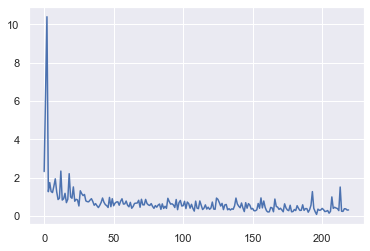

In [32]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt

plt.plot(list(range(len(train_losses))), train_losses)
plt.savefig("Loss.png", dpi=1080)
plt.show()


In [33]:

test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]          


In [34]:
  import scipy.io as io
  test_losses = []
  test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.unsqueeze(1)
      #print("data:")
      #print(data.shape)
      output = network(data)
      #print("output:")
      #print(output.shape)
      
      test_loss += F.nll_loss(output, target, size_average=False).item()
      #print(output)
      pred = output.data.max(1, keepdim=True)[1]
      #print(pred)##
      #print(target)
      result1 = np.array(pred)
      np.savetxt('pred.txt',result1)
      result2 = np.array(target)
      np.savetxt('target.txt',result2)
      
      #Save done
      correct += pred.eq(target.data.view_as(pred)).sum()
      
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


Test set: Avg. loss: 0.6344, Accuracy: 2408/2900 (83%)



C:\Users\PCI\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [35]:
'''
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()
'''

"\nfor epoch in range(1, n_epochs + 1):\n  train(epoch)\n  test()\nimport matplotlib.pyplot as plt\nfig = plt.figure()\nplt.plot(train_counter, train_losses, color='blue')\nplt.scatter(test_counter, test_losses, color='red')\nplt.legend(['Train Loss', 'Test Loss'], loc='upper right')\nplt.xlabel('number of training examples seen')\nplt.ylabel('negative log likelihood loss')\nplt.show()\n"

[[378   6 326  15]
 [  0 686  37   2]
 [ 31   2 638  54]
 [  6   0  13 706]]


[Text(0, 0.5, 'Normal'),
 Text(0, 1.5, 'Acute'),
 Text(0, 2.5, 'Chronic'),
 Text(0, 3.5, 'Pre-seizure')]

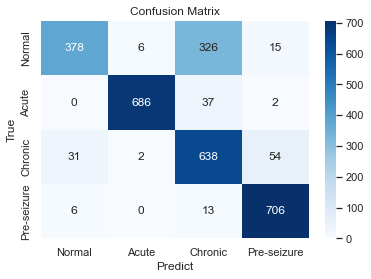

In [36]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

sns.set()
f,ax = plt.subplots()
y_true =(target)
y_pred = (pred)
C2 = confusion_matrix(y_true,y_pred,labels=[0,1,2,3])
#打印 C2
print(C2)
a=sns.heatmap(C2,annot=True,ax=ax, cmap = 'Blues', fmt='g') #画热力图  , cbar = None

ax.set_title('Confusion Matrix') #标题
ax.set_xlabel('Predict') #x 轴
ax.set_ylabel('True') #y 轴


#Normal, Acute, Chronic, Pre-seizure
a.set_xticklabels(['Normal','Acute','Chronic','Pre-seizure'])
a.set_yticklabels(['Normal','Acute','Chronic','Pre-seizure'])


In [37]:
from sklearn.metrics import f1_score
 
y_true = target
y_pred = pred
 
print(f1_score(y_true, y_pred, average='weighted'))# unbalance F1
print(f1_score(y_true, y_pred, average='macro'))

0.8259677257491832
0.8259677257491833


[[52.14  0.83 44.97  2.07]
 [ 0.   94.62  5.1   0.28]
 [ 4.28  0.28 88.    7.45]
 [ 0.83  0.    1.79 97.38]]


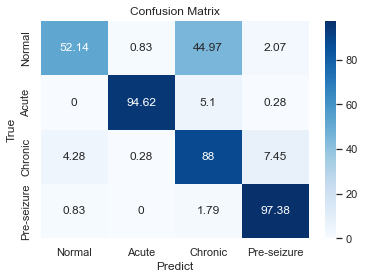

In [38]:
#plt.figure(dpi=10000)
#plt.figure(figsize=(10000, 10000))
sns.set()
f,ax = plt.subplots()
y_true =(target)
y_pred = (pred)
C2 = confusion_matrix(y_true,y_pred,labels=[0,1,2,3])

fm=C2.sum(axis=1)
C3=C2/fm*100
C3=np.around(C3,decimals=2)

print(C3)

a=sns.heatmap(C3,annot=True,ax=ax, cmap = 'Blues', fmt='g') #画热力图  , cbar = None

#ax.figure.set_size_inches(12,12)
ax.set_title('Confusion Matrix') #标题
ax.set_xlabel('Predict') #x 轴
ax.set_ylabel('True') #y 轴


#Normal, Acute, Chronic, Pre-seizure
a.set_xticklabels(['Normal','Acute','Chronic','Pre-seizure'])
a.set_yticklabels(['Normal','Acute','Chronic','Pre-seizure'])

fig = a.get_figure()
fig.savefig("16F_4C.png", dpi=1080)